# Example code for the optimal cleanup techniques

This notebook implements the optimized clean-up algortihms from our comparative analysis.  
The KF, YAPS, and a combination of both are shown here.  
The example uses all recorded data from fish '103' for the second deployment.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-packages" data-toc-modified-id="Import-packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import packages</a></span></li><li><span><a href="#Import-data" data-toc-modified-id="Import-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import data</a></span></li><li><span><a href="#Generation-of-TOA-matrices-for-YAPS" data-toc-modified-id="Generation-of-TOA-matrices-for-YAPS-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generation of TOA matrices for YAPS</a></span></li><li><span><a href="#Running-YAPS" data-toc-modified-id="Running-YAPS-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Running YAPS</a></span></li><li><span><a href="#Implementation-of-outlier-filter,-KF-and-RTSS-for-VPS-data" data-toc-modified-id="Implementation-of-outlier-filter,-KF-and-RTSS-for-VPS-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Implementation of outlier filter, KF and RTSS for VPS data</a></span></li><li><span><a href="#Implementation-of-KF-and-RTSS-for-YAPS-data" data-toc-modified-id="Implementation-of-KF-and-RTSS-for-YAPS-data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Implementation of KF and RTSS for YAPS data</a></span></li><li><span><a href="#Plot-results" data-toc-modified-id="Plot-results-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Plot results</a></span></li></ul></div>

## Import packages

In [1]:
import pandas as pd
import numpy as np
import cleanup_tools

## Import data

Define path were this github folder is located

In [2]:
git_path = 'C:/Users/Thoma/Documents/Github/Thesis_fish_data_cleanup/'

Read in raw TOA data

In [3]:
raw_data = pd.read_pickle(''.join((git_path,'Example_data/raw_data_103.pkl')))

Unfiltered VPS data

In [4]:
VPS_data =  pd.read_csv(''.join((git_path,'Example_data/TRANSMITTER-103-CALC-POSITIONS.csv')),parse_dates = [2])
VPS_data = cleanup_tools.to_reference_coord(VPS_data,('LON','LAT'),('X','Y'))

Hydrophone locations

In [5]:
hydro = pd.read_csv(''.join((git_path,'Site_data/Receiver_location.csv')),index_col= [0])

Canal wall data

In [6]:
wall_data  = pd.read_csv(''.join((git_path,'Site_data/walls-nodes.csv')))
wall_data = cleanup_tools.to_reference_coord(wall_data,('x','y'),('X','Y'))

Temperature data

In [7]:
all_temp_data = pd.read_csv(''.join((git_path,'Site_data/all_watertemp_data.csv')),index_col= 0,parse_dates= [0])

Known fish length, for the calculation of the max swimming speed

In [8]:
length_data = pd.read_csv(''.join((git_path,'Site_data/all_lengths.csv')))

## Generation of TOA matrices for YAPS

In [9]:
# Define minimum amount of transmissions. If too small, YAPS can't calculate the track
min_obs = 50
# Define passing tollerance, in minutes. 
# Is there is no signal for linger than the pas_tol, the track is declared lossed and a new one starts
pas_tol = 2
# Define the ID for the functions
ID = 103

In [10]:
# Get the minimum and paximum delay time of the transmitter
min_delay,max_delay = cleanup_tools.find_delay(ID)
# Calculate the maximum travel time between hydrophones to split the track
raw_data = cleanup_tools.calculate_max_time(raw_data,hydro,all_temp_data)
# Split up the track, reformat for YAPS 
TOA_data = cleanup_tools.prepare_tag_data(raw_data,pas_tol)
# Clean the TOA data using the minimum burst interval
TOA_data = cleanup_tools.clean_toa_data(TOA_data,min_delay)
# include mean BI for YAPS-BI
TOA_data.loc[:,('mean_BI')] = (max_delay+min_delay)/2
# Split the TOA dat into individual tracks, usable by YAPS
end_data_split,timestamps = cleanup_tools.split_passings(TOA_data,min_obs)
# write out the TOA matrix for YAPS
end_data_split.to_csv(''.join((git_path,'Example_data/TOA_data_',str(ID),'.csv')),na_rep = 'NA')                      

## Running YAPS

The generated TOA data can now be used by YAPS-BI.  
This is done as follows:
 - Install the 'zoo' and 'TMB' packages, required by YAPS 
 - Open the 'YAPS_runMe.R file' in R
 - Change the path to the one entered for 'git_path'
 - Run all lines

## Implementation of outlier filter, KF and RTSS for VPS data

In [11]:
# Parameters are defined globally here, based on the analysis of all tracks
beta = 0.0105
sigma = 0.045

In [12]:
# Extract the VPS data patching the raw TOA data used by YAPS
for i in range(0,len(timestamps)):
    mask = (VPS_data['DATETIME']>=timestamps.iloc[i,0])&(VPS_data['DATETIME']<=timestamps.iloc[i,1])
    VPS_data.loc[mask,'pas_nr'] = timestamps.index[i]
    fish_data = VPS_data[~VPS_data.pas_nr.isna()]
# If length data is available, this length is used to calculate the maximum swimming speed.
# If not, the top 5% swimming speeds are removed
if  sum(length_data.ID == int(ID)) ==1:   
    max_speed = cleanup_tools.max_swimming_speed(ID,length_data)
else: 
    max_speed = 'infer'
# The three stage outlier filter is implemented by running the angle filter after the two stage speed filter
KF_track = cleanup_tools.angle_filter(
    cleanup_tools.two_stage_speed_filter(fish_data,max_speed=max_speed)).reset_index()
# The KF track is calculated for every passing, using the CTCRW model and HPE as an error measure
KF_track = cleanup_tools.iterate_over_passings(KF_track,beta,sigma)

# Because the outlier filter removed some positions, the only index has to be used to link to the raw VPS data
out_data = fish_data.copy()
index = KF_track['index']
out_data.loc[index,'X_outl']= KF_track.loc[:,'X'].values
out_data.loc[index,'Y_outl']= KF_track.loc[:,'Y'].values
out_data.loc[index,'X_filtered']= KF_track.loc[:,'X_filtered'].values
out_data.loc[index,'Y_filtered']= KF_track.loc[:,'Y_filtered'].values
out_data.loc[index,'filtered_error']= KF_track.loc[:,'filtered_error'].values

columns = ('DATETIME','X','Y','HPE','X_outl','Y_outl','X_filtered','Y_filtered','filtered_error','URX','pas_nr')

out_data.to_csv(''.join((git_path,'Example_data/VPS_track_cleaned_',str(ID),'.csv')),columns=columns)

C:\Users\Thoma\Documents\GitHub\Thesis_fish_data_cleanup\cleanup_tools.py:54: RuntimeWarning: invalid value encountered in arccos
  angle = 180 - np.abs(180/np.pi*np.arccos((dist**2 + dist.shift(-1)**2 - (double_dist)**2)/(2*dist*dist.shift(-1))))


## Implementation of KF and RTSS for YAPS data

In [13]:
YAPS_data = pd.read_csv(''.join((git_path,"Example_data/YAPS_track_",str(ID),".csv")),index_col = [0],parse_dates = [-1])
# name in accordance to VPS results
YAPS_data.rename(columns={"synced_time": "DATETIME", "x": "X","y":"Y"},inplace=True)

passings = YAPS_data.pas_nr.unique()
YAPS_data_out = pd.DataFrame()
for i, pas in enumerate(passings):
    YAPS_track = YAPS_data[YAPS_data.pas_nr == pas].reset_index(drop = True)
    # YAPS gives error sensitivity in both dimesnions seperately, we calculate the overall error sensitivity
    YAPS_track['sd_xy'] = np.sqrt(YAPS_track.sd_x**2+YAPS_track.sd_y**2)
    # filter the YAPS results with the KF and RTSS
    YAPS_track = cleanup_tools.iterate_over_passings(YAPS_track,beta,sigma, errorcol ='sd_xy')
    YAPS_data_out = pd.concat((YAPS_data_out,YAPS_track))
YAPS_data_out.to_csv(''.join((git_path,"Example_data/YAPS_track_cleaned_",str(ID),".csv")),index=False)

## Plot results

Plots KF results vor the traditional approack, YAPS results, and YAPS + KF + RTSS  
**Waring:** if no pas_nr is passed, all tracks are plotted, which uses a lot of memory

In [14]:
passings

array([ 271,  320,  326,  388,  700,  730,  750, 1060, 1061, 1193, 1234,
       1249, 1306, 1323, 1324, 1363, 1485, 1488, 1506, 1526, 1528, 1542,
       1580, 1604, 1609, 1610, 1639, 1640, 1668, 1721, 1722, 1723, 1789,
       1812, 1814, 1838, 1841, 1844, 1851, 1856, 1869, 1883, 1884, 1885,
       1892, 1894, 1895, 1896, 1904, 1908, 1910, 1913, 1915, 1929, 1934,
       1937, 1943, 1991, 1993], dtype=int64)

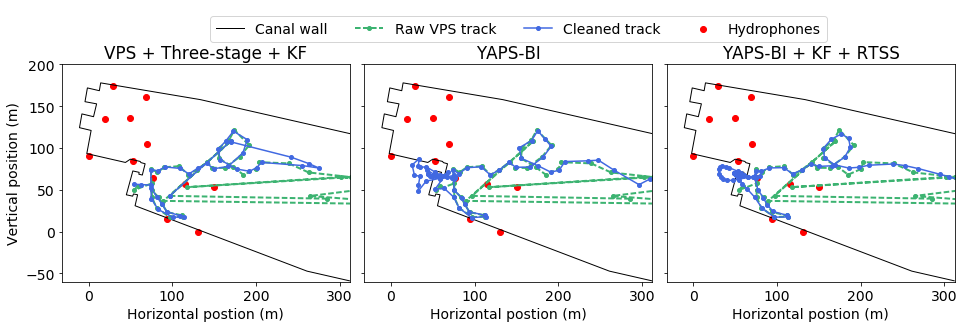

In [15]:
cleanup_tools.plot_fish_tracks(ID,git_path,hydro,wall_data,pas_nr= 1991)